In [1]:
import sys
sys.path.append('../../ml_utils')

import config as cfg
import data_utils as du
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt
import joblib
import sklearn

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

%matplotlib inline

In [2]:
print("joblib (0.14.1): {}\n".format(joblib.__version__))
print("numpy (1.17.4): {}\n".format(np.__version__))
print("pandas (0.25.3): {}\n".format(pd.__version__))
print("sklearn (0.22): {}\n".format(sklearn.__version__))

joblib (0.14.1): 0.14.0

numpy (1.17.4): 1.17.4

pandas (0.25.3): 0.25.3

sklearn (0.22): 0.22



In [3]:
log_data = './../../shared/data/swissid_authorize_logs_april_to_sept_2019.csv'

start = timeit.default_timer()
df = pd.read_csv(filepath_or_buffer=log_data, header=0, sep='\t', names=cfg.complete_feature_list, index_col=None)
stop = timeit.default_timer()

print("Original data frame size: {}\n".format(df.shape))
print("Time: {} seconds\n".format(stop - start))

Original data frame size: (12417597, 31)

Time: 48.607216495 seconds



In [4]:
df = du.clean_data(df)

columns with NaN: loc_country_code
loc_country_code is fixed


In [5]:
features = ['label_nr', 'src_software_sub_type', 'src_operating_system_name', 'src_hardware_type', 'response_status_code', 
            'oidc_client_id', 'oidc_scopes', 'oidc_ui_locales', 'loc_city', 'loc_country_code', 'date_weekday']

excludes = list(set(df.columns.tolist()) - set(features))

In [6]:
reduced_df = du.reduce_features(df, excludes)

print("reduced data frame size: {}\n".format(reduced_df.shape))
#display(reduced_df)

reduced data frame size: (12204748, 11)



In [7]:
#reduced_df.dtypes

In [8]:
print(reduced_df['label_nr'].value_counts())

2    7412813
0    4769169
1      22766
Name: label_nr, dtype: int64


In [9]:
sample_size= 1000000
exclude = ['label_nr']

X_df, y_df, anomaly_rate, encoder = du.build_normal_anomaly_sample_df(reduced_df, sample_size, exclude)

print(y_df.value_counts())
#display(X_df)

build data sets...
shuffling data...
encode dataframe...
encoding src_operating_system_name
encoding src_software_sub_type
encoding src_hardware_type
encoding oidc_client_id
encoding oidc_scopes
encoding oidc_ui_locales
encoding loc_city
encoding loc_country_code
0    995226
1      4774
Name: label_nr, dtype: int64


In [10]:
x_train, x_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state = 42)

print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))

Shapes:
x_train:(800000, 10)
y_train:(800000,)

x_test:(200000, 10)
y_test:(200000,)



In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

# Grid Search over contamination fraction
skf = StratifiedKFold(n_splits=3) 
folds = list(skf.split(x_train, y_train))

forest = IsolationForest()
forest.contamination = anomaly_rate

f1sc = make_scorer(f1_score, average='micro')

parameters = {'n_estimators': (80, 90, 100, 110, 120), 'max_samples':[256, 384, 'auto'], 'verbose':[2], 'n_jobs':[5]}
search = GridSearchCV(estimator=forest, param_grid=parameters, scoring=f1sc, cv=folds)

start = timeit.default_timer()
search.fit(x_train, y_train)
stop = timeit.default_timer()

runtime = stop - start

print("Time: {} seconds\n".format(runtime))
print("Time: {} minutes\n".format(runtime/60))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.0s remaining:    2.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(

Building estimator 1 of 24 for this parallel run (total 120)...Building estimator 1 of 24 for this parallel run (total 120)...
Building estimator 1 of 24 for this parallel run (total 120)...
Building estimator 1 of 24 for this parallel run (total 120)...

Building estimator 1 of 24 for this parallel run (total 120)...
Building estimator 2 of 24 for this parallel run (total 120)...
Building estimator 2 of 24 for this parallel run (total 120)...
Building estimator 2 of 24 for this parallel run (total 120)...Building estimator 2 of 24 for this parallel run (total 120)...

Building estimator 2 of 24 for this parallel run (total 120)...
Building estimator 3 of 24 for this parallel run (total 120)...
Building estimator 3 of 24 for this parallel run (total 120)...Building estimator 3 of 24 for this parallel run (total 120)...

Building estimator 3 of 24 for this parallel run (total 120)...
Building estimator 3 of 24 for this parallel run (total 120)...
Building estimator 4 of 24 for this para

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.8s finished


Time: 986.2753418379999 seconds

Time: 16.437922363966667 minutes



In [12]:
param = search.best_params_
param

{'max_samples': 'auto', 'n_estimators': 120, 'n_jobs': 5, 'verbose': 2}

In [13]:
iforest_clf = IsolationForest(n_estimators=param['n_estimators'], max_samples=param['max_samples'], contamination=anomaly_rate)

start = timeit.default_timer()
iforest_clf.fit(x_train)
stop = timeit.default_timer()

print("Time: {} seconds\n".format(stop - start))

Time: 28.34471996100001 seconds



In [14]:
y_scores = iforest_clf.decision_function(x_test)
y_truth = y_test.values == cfg.label_anomaly_idx

res, fpr_values, tpr_values = du.calc_best_threshold(y_truth, y_scores)
res

{'best_auc': 0.9494228959763339,
 'best_auc_threshold': 0.0823334457549226,
 'best_f1_score': 0.8703271028037384,
 'best_f1_score_threshold': -0.027666554245077402}

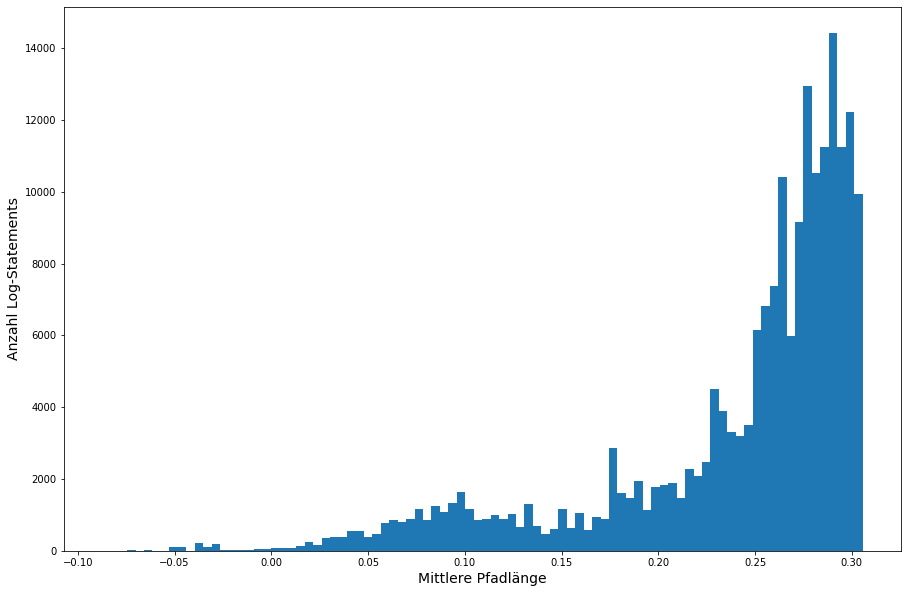

In [15]:
plt.figure(figsize=(15, 10))
plt.hist(y_scores, bins=90)
plt.xlabel('Mittlere Pfadlänge', fontsize=14)
plt.ylabel('Anzahl Log-Statements', fontsize=14)
plt.show()

In [16]:
y_predictions = y_scores < 0
y_truth = y_test.values == cfg.label_anomaly_idx
    
auc = roc_auc_score(y_truth, y_predictions)
print("AUC: {:.2%}".format (auc))

AUC: 90.51%


In [17]:
y_predictions = y_scores < res['best_auc_threshold']
res_2 = du.calc_metrics(y_truth, y_predictions)
res_2

{'total': 200000,
 'tot_anomaly': 947,
 'tot_normal': 199053,
 'tpr_recall': 0.9450897571277719,
 'precision': 0.08861386138613861,
 'accuracy': 0.953715,
 'f1_score': 0.1620349416131076,
 'fnr': 0.054910242872228086,
 'tnr': 0.9537560348248959,
 'fpr': 0.04624396517510412,
 'conf_matrix': [[895, 9205], [52, 189848]],
 'auc': 0.9494228959763339}

In [18]:
y_predictions = y_scores < res['best_f1_score_threshold']
res_3 = du.calc_metrics(y_truth, y_predictions)
res_3

{'total': 200000,
 'tot_anomaly': 947,
 'tot_normal': 199053,
 'tpr_recall': 0.7866948257655755,
 'precision': 0.9738562091503268,
 'accuracy': 0.99889,
 'f1_score': 0.8703271028037384,
 'fnr': 0.2133051742344245,
 'tnr': 0.999899524247311,
 'fpr': 0.00010047575268898233,
 'conf_matrix': [[745, 20], [202, 199033]],
 'auc': 0.8932971750064432}

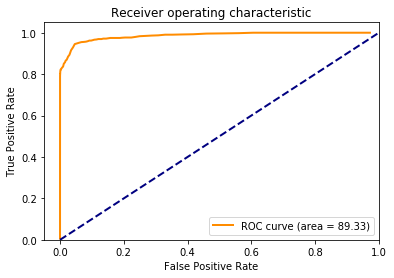

In [19]:
plt.figure()
plt.plot(fpr_values, tpr_values, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % (100*res_3['auc']))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Persist the classifier

In [20]:
path_clf = './../../shared/models/iforest/optimized_iforest_encoded_clf_all.pkl'
path_enc = './../../shared/models/iforest/optimized_iforest_encoder_all.pkl'

# save the classifier to disk
joblib.dump(iforest_clf, path_clf)
joblib.dump(encoder, path_enc)

['./../shared/models/iforest/optimized_iforest_encoder_all.pkl']

## Reload the classifier and predict
predict again to test if all works fine

In [21]:
# load the classifier from disk
loaded_clf = joblib.load(path_clf)

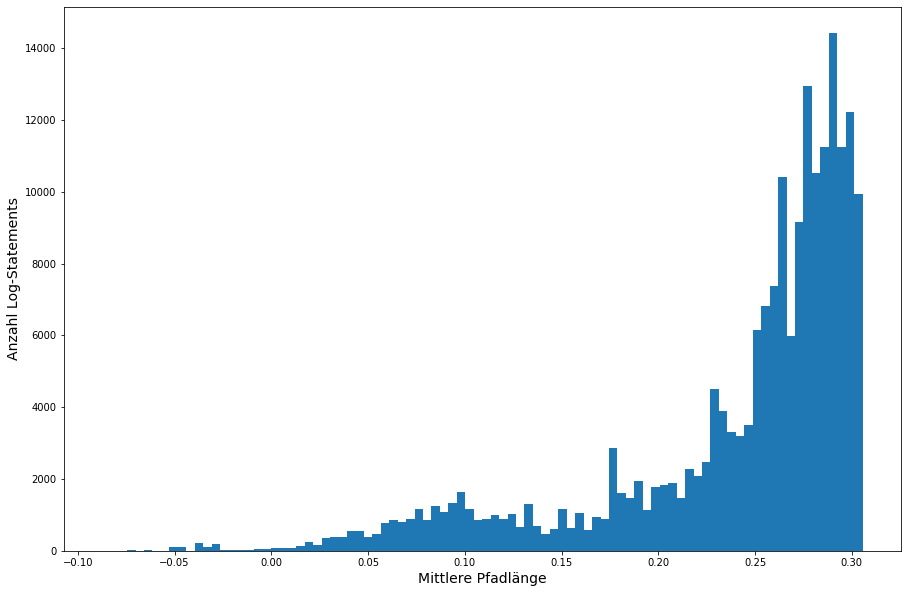

In [22]:
y_scores = loaded_clf.decision_function(x_test)

plt.figure(figsize=(15, 10))
plt.hist(y_scores, bins=90)
plt.xlabel('Mittlere Pfadlänge', fontsize=14)
plt.ylabel('Anzahl Log-Statements', fontsize=14)
plt.show()

In [23]:
y_predictions = y_scores < res['best_f1_score_threshold']
res_4 = du.calc_metrics(y_truth, y_predictions)
res_4

{'total': 200000,
 'tot_anomaly': 947,
 'tot_normal': 199053,
 'tpr_recall': 0.7866948257655755,
 'precision': 0.9738562091503268,
 'accuracy': 0.99889,
 'f1_score': 0.8703271028037384,
 'fnr': 0.2133051742344245,
 'tnr': 0.999899524247311,
 'fpr': 0.00010047575268898233,
 'conf_matrix': [[745, 20], [202, 199033]],
 'auc': 0.8932971750064432}